# 0: Basic Functions

Demonstrate the usage of the basic functions.

@author: Guihong Wan and Boshen Yan      
@date: July 20, 2023    
@last updated: Oct 6, 2023

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import statistics

import spatialcells as spc

## Read data

In [29]:
adata = ad.read("../data/tutorial_adata.h5ad")
adata.obs["id"] = adata.obs_names

## setGate or setGates

This package relies on gated biomarkers in adata.obs

If gating has not yet been performed, `setGate` and `setGates` are convenience functions to gate the dataset manually or via a csv file

In [30]:
# New columns, SOX10_positive and CD45_positive, will be added
spc.prep.setGate(adata, "SOX10", 7.5, marker_suffix="_positive", debug=True)
spc.prep.setGate(adata, "CD45", 8.0, marker_suffix="_positive", debug=True)

SOX10_positive
False    91523
True     46293
Name: count, dtype: int64
CD45_positive
False    98518
True     39298
Name: count, dtype: int64


In [31]:
# A column ending with "_positive" for each marker will be added
gate_file = "../data/tutorial_gates.csv"
spc.prep.setGates(adata, gate_file, debug=True, marker_suffix="_positive")

gate: 7.5 SOX10_positive
False    91523
True     46293
Name: count, dtype: int64
gate: 7.0 CD8A_positive
False    116836
True      20980
Name: count, dtype: int64
gate: 7.2 CD3E_positive
False    111855
True      25961
Name: count, dtype: int64
gate: 8.0 CD45_positive
False    98518
True     39298
Name: count, dtype: int64
gate: 6.5 panCK_positive
False    129174
True       8642
Name: count, dtype: int64
gate: 7.4 CD4_positive
False    113595
True      24221
Name: count, dtype: int64
gate: 5.7 aSMA_positive
False    129847
True       7969
Name: count, dtype: int64


In [32]:
adata

AnnData object with n_obs × n_vars = 137816 × 7
    obs: 'X_centroid', 'Y_centroid', 'id', 'SOX10_positive', 'CD45_positive', 'CD8A_positive', 'CD3E_positive', 'panCK_positive', 'CD4_positive', 'aSMA_positive'
    uns: 'all_markers'

Visualizing cells with markers of interest

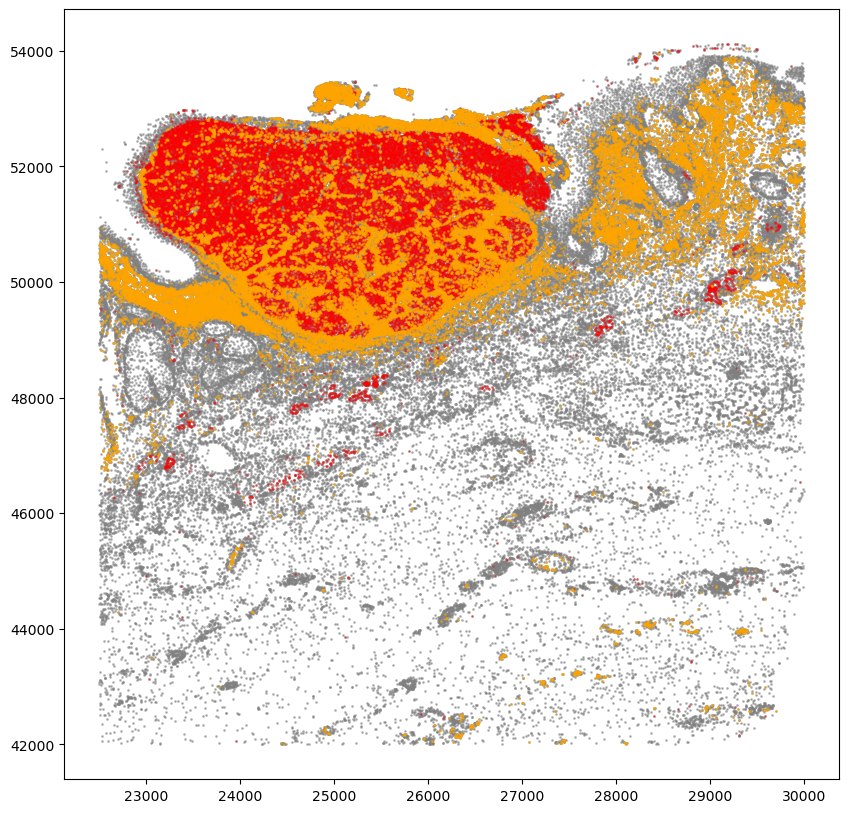

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=1,
    color="grey",
    alpha=0.5
)

## SOX10+ cells
tmp = adata[adata.obs.SOX10_positive]
ax.scatter(
    *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), s=1, color="red", alpha=0.3
)

## CD45+ cells
tmp = adata[adata.obs.CD45_positive]
ax.scatter(
    *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=1,
    color="orange",
    alpha=0.5
)
plt.show()

The following steps compute the communities based on SOX10+ or CD45+ cells.

## getCommunities

We first use DBSCAN via `getCommunities` to identify regions with high densities of markers of interest. 

Optionally, `estimateInitialDistance` can be run first to estimate the eps parameter for DBSCAN.    
In this tutorial, we used a threshold between the first quartile and median.

In [34]:
markers_of_interest = ["SOX10_positive", "CD45_positive"]
eps_estims = spc.spa.estimateInitialDistance(
    adata, markers_of_interest, sampling_ratio=0.1
)
eps_estims

Computing distances...


[16.953524326607617,
 31.130626822363674,
 52.40063779123195,
 82.41078276475527,
 158.91378568067233,
 258.05023430098896,
 436.44338139746947,
 794.2173284357773,
 1509.7633490222295,
 2539.5002631784005,
 4622.377206584879,
 9193.812141019682,
 25326.076069722287,
 48604.744886592984,
 170424.39109471775]

In [35]:
print(statistics.quantiles(eps_estims))

[82.41078276475527, 794.2173284357773, 9193.812141019682]


In [36]:
help(spc.spa.getCommunities)

Help on function getCommunities in module spatialcells.spatial._getCommunities:

getCommunities(adata, markers_of_interest, eps, min_samples=20, newcolumn='COI_community', core_only=False)
    Get the communities of interest (COI) using DBSCAN
    :param adata: the anndata object
    :param markers_of_interest: the list of marker names to subset the data
    :param eps: the eps parameter for DBSCAN
    :param min_samples: Minimum number of samples in each community
    :param newcolumn: the column name of the community
    :return: the communities of interest (COI)



In [37]:
markers_of_interest = ["SOX10_positive", "CD45_positive"]

communitycolumn = "COI_community"
ret = spc.spa.getCommunities(
    adata,
    markers_of_interest,
    eps=90,  # smaller --> more cells are considered as outliers.
    newcolumn=communitycolumn,
)
print("number of communities:", len(ret[0]))

number of communities: 26


Visualize the communities identified

In [38]:
help(spc.plt.plotCommunities)

Help on function plotCommunities in module spatialcells.plotting._plotCommunities:

plotCommunities(adata, ret, communitycolumn, plot_first_n_clusters=10, **kwargs)
    Plot largest communities on a scatter plot. Each community is labelled as:
    (rank in descending number of cells : index of community)
    
    :param adata: AnnData object
    :param ret: return value of spc.spa.getCommunities
    :param communitycolumn: column name of the community column in adata.obs
    :param plot_first_n_clusters: plot and number the largest n communities
    :param kwargs: keyword arguments for matplotlib.pyplot.plot



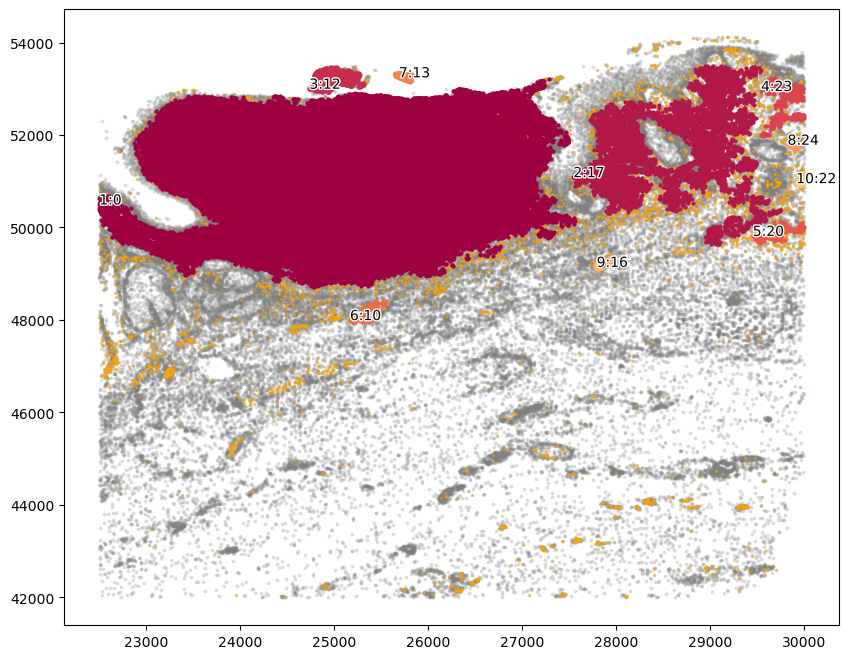

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata, ret, communitycolumn, plot_first_n_clusters=10, s=2, fontsize=10, ax=ax
)
plt.show()

In [40]:
clusters_idx_sorted = [idx for npoints, idx in ret[0]]
plot_first_n_clusters = 10
print(
    "Indexes of the",
    plot_first_n_clusters,
    "largest clusters:\n",
    clusters_idx_sorted[:plot_first_n_clusters],
)
print("Cluster size and index:\n", ret[0][:plot_first_n_clusters])

# Here we choose the three largest ones of interest based on their index:
communityIndexList = [0, 17, 12]

Indexes of the 10 largest clusters:
 [0, 17, 12, 23, 20, 10, 13, 24, 16, 22]
Cluster size and index:
 [(68681, 0), (7543, 17), (1218, 12), (600, 23), (234, 20), (167, 10), (161, 13), (82, 24), (75, 16), (67, 22)]


## getBoundary    

In [41]:
help(spc.spa.getBoundary)

Help on function getBoundary in module spatialcells.spatial._getBoundary:

getBoundary(anndata, communitycolumn, communityIndexList, alpha=100, debug=False)
    Get a boundary for the communities of interest as a Shapely MultiPolygon. 
    
    The boundary is defined based on the alpha shape of points in the 
    communities. The alpha shape is the generalization of the convex hull, 
    and is generated via Delaunay triangulation of all the points of interest. 
    The alpha parameter controls the longest edge that can appear in the alpha 
    shape. Smaller alpha gives more detailed boundary, but may appear more 
    jagged and may leave out some points that are too far away from the rest 
    of the points.
    
    :param anndata: the anndata object
    :param communitycolumn: the column name of the community
    :param communityIndexList: the list of community indexes
    :param alpha: the alpha parameter for alpha shape. Smaller alpha gives
        more detailed boundary, but ma

In [42]:
help(spc.spa.pruneSmallComponents)

Help on function pruneSmallComponents in module spatialcells.spatial._utils:

pruneSmallComponents(boundary, min_area=0, min_edges=0, holes_min_area=0, holes_min_edges=0)
    Prune small components from a boundary defined by a MultiPolygon.
    :param boundary: the boundary to prune
    :param min_area: the minimum area of a polygon component to keep
    :param min_edges: the minimum number of edges of a polygon component to keep
    :param holes_min_area: the minimum area of a hole to keep the hole
    :param holes_min_edges: the minimum number of edges of a hole to keep the hole
    :return: the pruned boundary



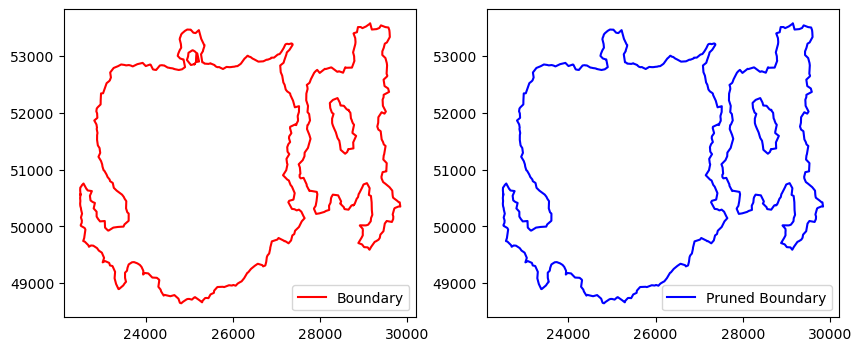

In [43]:
boundary = spc.spa.getBoundary(adata, communitycolumn, communityIndexList, alpha=80)
# filter out small regions or holes based on the number of edges
# or the area of the region
boundary_pruned = spc.spa.pruneSmallComponents(
    boundary, min_edges=50, holes_min_edges=50, holes_min_area=50000
)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
spc.plt.plotBoundary(boundary, ax=ax1, color="r", label="Boundary")
ax1.legend()

spc.plt.plotBoundary(boundary_pruned, ax=ax2, color="b", label="Pruned Boundary")
ax2.legend()
plt.show()

Visualization of regions of interest and boundary

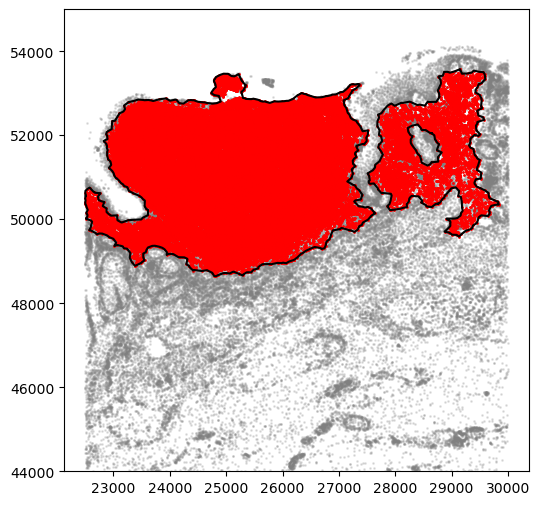

In [44]:
markersize = 1

fig, ax = plt.subplots(figsize=(6, 6))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")

# Boundary of selected communities
spc.plt.plotBoundary(boundary_pruned, ax=ax)
plt.ylim(44000, 55000)
plt.show()

## getExtendedBoundary & getShrunkenBoundary

`getExtendedBoundary` and `getShrunkenBoundary` can be used to expand or shrink the current boundary, which is useful to generate regions of interest

In [45]:
# note: In this dataset, 1px = 0.6um
# For this example, the offset is converted from um to px

# Remove background. Anything beyond this will not be considered
ROI_boundary = spc.spa.getExtendedBoundary(boundary_pruned, offset=800 / 0.6)

shrunken_boundary = spc.spa.getShrunkenBoundary(boundary_pruned, offset=100 / 0.6)

extended_boundary = spc.spa.getExtendedBoundary(boundary_pruned, offset=200 / 0.6)

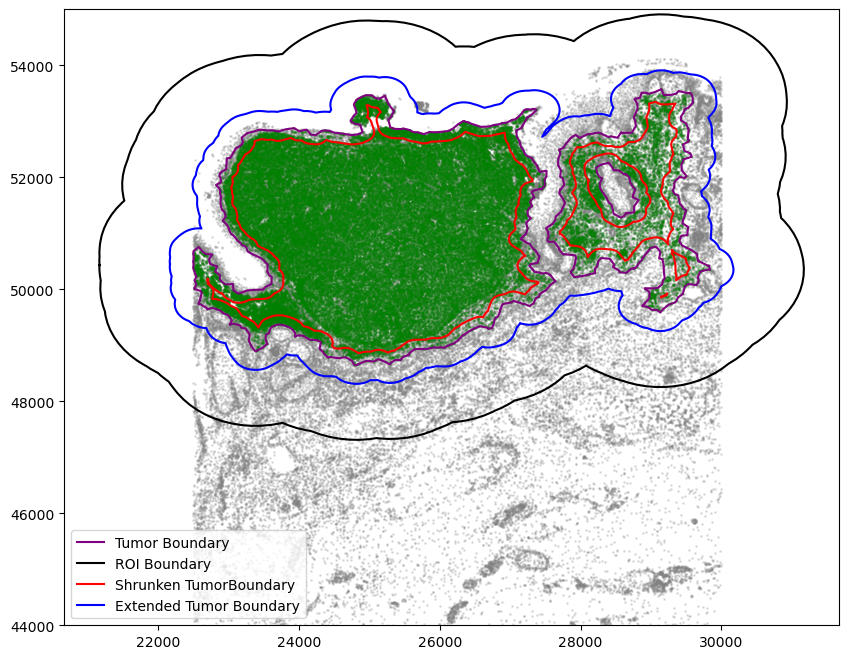

In [46]:
pointsize = 1
fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="green", alpha=0.2)

# Bounds of points in selected commnities
spc.plt.plotBoundary(boundary_pruned, color="purple", label="Tumor Boundary", ax=ax)
spc.plt.plotBoundary(ROI_boundary, color="k", label="ROI Boundary", ax=ax)
spc.plt.plotBoundary(
    shrunken_boundary, color="r", label="Shrunken TumorBoundary", ax=ax
)
spc.plt.plotBoundary(
    extended_boundary, color="b", label="Extended Tumor Boundary", ax=ax
)

plt.legend(loc="lower left")
plt.ylim(44000, 55000)
plt.show()

## assignPointsToRegion

Using 1 or more generated boundaries, cells can be assigned to different regions for downstream analysis

In [47]:
help(spc.spatial.assignPointsToRegions)

Help on function assignPointsToRegions in module spatialcells.spatial._assignPointsToRegions:

assignPointsToRegions(anndata, boundaries_list, region_names, assigncolumn='region', default='BG')
    Assign points to regions based on the boundaries. The region assignment is
    based on the order of the boundaries, so the innermost region should be the
    first element of boundaries_list.
    :param anndata: Anndata object
    :param boundaries_list: List of boundaries
    :param region_names: List of region names. The order and length should match boundaries_list
    :param assigncolumn: Column name for the region assignment
    :param default: Default region name for points that are not assigned to any region



In [48]:
regions = ["Tumor", "Tumor Border", "Stroma Border", "Stroma"]
boundaries_list = [shrunken_boundary, boundary_pruned, extended_boundary, ROI_boundary]

spc.spatial.assignPointsToRegions(
    adata, boundaries_list, regions, assigncolumn="region", default="BG"
)

101863it [00:05, 18030.37it/s]


Assigned points to region: Tumor


40094it [00:03, 13306.75it/s]


Assigned points to region: Tumor Border


21464it [00:01, 21126.40it/s]


Assigned points to region: Stroma Border


14412it [00:00, 42888.78it/s]

Assigned points to region: Stroma


In [49]:
print("Regions:")
print(adata.obs["region"].cat.categories)
print("\nNumber of points in each region:")
print(adata.obs["region"].value_counts())

Regions:
Index(['Tumor', 'Tumor Border', 'Stroma Border', 'Stroma', 'BG'], dtype='object')

Number of points in each region:
region
Tumor            68712
Tumor Border     23921
BG               19368
Stroma Border    14502
Stroma           11313
Name: count, dtype: int64


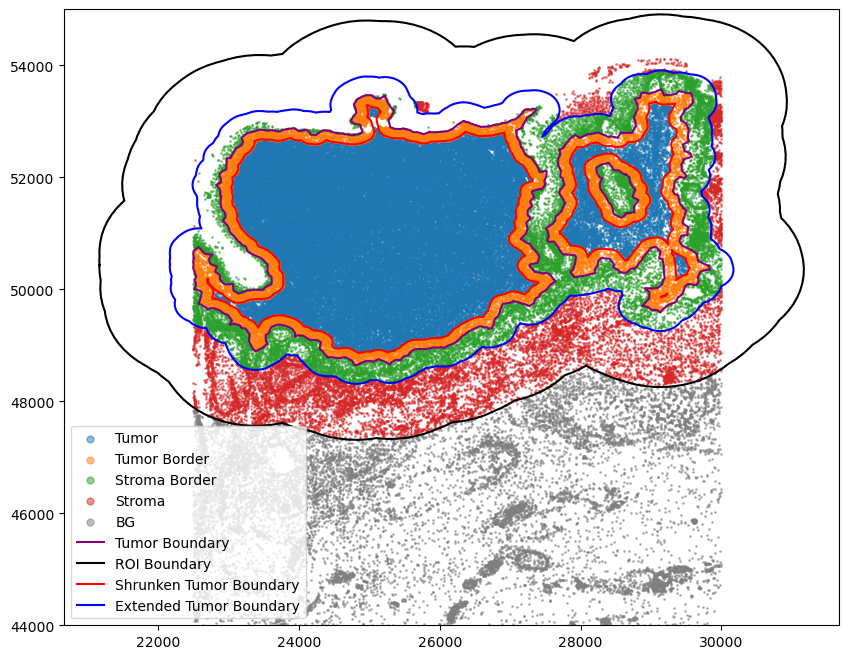

In [50]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:gray"]

point_size = 1
fig, ax = plt.subplots(figsize=(10, 8))

# get points in each region in order
for i, region in enumerate(adata.obs["region"].cat.categories):
    tmp = adata[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.5,
        label=region,
        color=colors[i]
    )

# Bounds of points in selected commnities
spc.plt.plotBoundary(boundary_pruned, color="purple", label="Tumor Boundary", ax=ax)
spc.plt.plotBoundary(ROI_boundary, color="k", label="ROI Boundary", ax=ax)
spc.plt.plotBoundary(
    shrunken_boundary, color="r", label="Shrunken Tumor Boundary", ax=ax
)
spc.plt.plotBoundary(
    extended_boundary, color="b", label="Extended Tumor Boundary", ax=ax
)
plt.legend(loc="lower left", markerscale=5)
plt.ylim(44000, 55000)
plt.show()

Save adata object with cells assigned to each region for downstream analysis:

In [51]:
# adata.save("../data/tutorial_adata_regions.h5ad")

Save the boundary objects generated as geojson type files

In [52]:
spc.utils.exportRegion(boundary_pruned, "../data/tutorial_boundary.json")
spc.utils.exportRegion(ROI_boundary, "../data/tutorial_ROI_boundary.json")
spc.utils.exportRegion(shrunken_boundary, "../data/tutorial_shrunken_boundary.json")
spc.utils.exportRegion(extended_boundary, "../data/tutorial_extended_boundary.json")

'{"type":"MultiPolygon","coordinates":[[[[22169.31133706403,50446.56500486768],[22167.6743962764,50461.659103059006],[22166.42609038452,50476.087650966896],[22166.420484286034,50476.174344068095],[22165.80878046444,50505.125940644786],[22165.81071980408,50505.212793169776],[22167.714096442618,50534.10823023869],[22167.723566583958,50534.19458670086],[22169.614660491174,50548.553034600984],[22172.350929342756,50566.33542811828],[22168.56523828346,50602.38075822068],[22167.389064211515,50616.43682294047],[22167.383794297722,50616.521270853445],[22166.819616175904,50644.7196894959],[22166.82150405163,50644.8042806179],[22167.43451022294,50658.89614224832],[22170.161617781083,50701.03131666692],[22171.631043678746,50717.43519126532],[22171.64228559223,50717.533336704146],[22177.000934688163,50750.02345777162],[22177.021805424378,50750.12001511287],[22185.559997139317,50781.9228824129],[22185.59029302267,50782.0169093624],[22197.224703937824,50812.82216167089],[22197.26412931359,50812.91274